In [1]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import time
import seaborn as sns
import os
from scipy.stats import zscore

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score, precision_score, recall_score, confusion_matrix

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
    
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [2]:
os.getcwd()
l19 = pd.read_csv("loans_fromR.csv")

In [3]:
#df.var().sort_values(axis=0, ascending=True)

# Changes from last stage

- After reviwing the columns we dropped we decided to return two columns for furture considaration since we think they might have some use for our model
- We decided to drop "emp_title" since it has too many unique values and will not benefit our model

In [4]:
print("emp_title number of unique values --> %d" % len(l19['emp_title'].unique()))
l19.drop('emp_title', axis=1, inplace=True)

emp_title number of unique values --> 75554


In [5]:
df = l19.copy() 

# Dealing with missing value

Checking missing value fractions

In [6]:
col_name = []
missing_value_prop = []
for i in df.columns: 
	# count number of rows with missing values
    n_miss = df[i].isnull().sum()
    if n_miss >0:
        col_name.append(i)
        missing_value_prop.append( n_miss / df.shape[0] * 100)
    
df_missing_val = pd.DataFrame({'Columns': col_name, 'missing_value_prop': missing_value_prop}) 

df_missing_val.sort_values("missing_value_prop")

,Columns,missing_value_prop
2,total_bal_il,0.0166
4,max_bal_bc,0.0166
5,all_util,0.0226
1,revol_util,0.0667
9,realized_return,0.1514
6,bc_open_to_buy,1.1464
8,percent_bc_gt_75,1.1551
7,bc_util,1.1969
3,il_util,13.9307
0,emp_length,14.8805


Looking at missing fraction we decided, for now, to drop instances of attributes with missing value of less then 1% since its neglegent.
For attributes with more then 1% missing values we will replace the NA with the median.
When we porgress and try to improve our model we will look into the option of using Knn imputation to replace missing values and see if it benefits us

In [7]:
missing_to_drop = []
for i in range(df.shape[1]):
    n_miss = df.iloc[:,i].isnull().sum()
    perc = n_miss / df.shape[0] * 100
    if perc <1 and perc>0 :
        missing_to_drop.append(df.columns[i]) # get columns names

        
for i in missing_to_drop:
    df =df[-df[i].isnull()]      

Fill NA of the rest of the columns with their median

In [8]:
df = df.fillna((df.median()))
#df_one_hot = df_one_hot.drop(["id"], axis = 1)

**-Parse dates**

In [9]:
df["issue_d"] = pd.to_datetime(df["issue_d"])
df["earliest_cr_line"] = pd.to_datetime(df["earliest_cr_line"], format= "%b-%y") 

-Create a feature for the length of a person's credit history at the
time the loan is issued


In [10]:
df['cr_hist'] = (df.issue_d - df.earliest_cr_line) / np.timedelta64(1, 'M')
df.drop(["issue_d", "earliest_cr_line"], inplace=True, axis = 1)

# Categorica attributes encoding

For attributes with 2 unique values we will simplly encode the values as "0" and "1", for attributes with more unique values we will examine them and decide on the most suitble way for encoding

-Get categorical and numeric column names

In [11]:
district_cols = df.select_dtypes([np.object]).columns
print (district_cols)

Index(['grade', 'sub_grade', 'home_ownership', 'verification_status',
       'loan_status', 'purpose', 'addr_state', 'initial_list_status'],
      dtype='object')


In [12]:
numeric_cols = df.select_dtypes([np.number]).columns
print (numeric_cols)

Index(['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'tot_coll_amt', 'tot_cur_bal',
       'total_bal_il', 'il_util', 'max_bal_bc', 'all_util', 'total_rev_hi_lim',
       'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mort_acc',
       'num_actv_bc_tl', 'num_bc_sats', 'num_bc_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tot_hi_cred_lim',
       'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',
       'realized_return', 'cr_hist'],
      dtype='object')


In [13]:
for i in district_cols: #count unique values
    print("%s --> %d " %(i,len(df[i].unique())))

grade --> 7 
sub_grade --> 35 
home_ownership --> 4 
verification_status --> 3 
loan_status --> 2 
purpose --> 13 
addr_state --> 50 
initial_list_status --> 2 


**loan_status** and **initial_list_status** will be encoded as 1 and 0

In [14]:
encoder = LabelEncoder()

df = df.replace({'loan_status': {'Charged Off': 1, 'Fully Paid': 0}})

df['initial_list_status'] = encoder.fit_transform(df['initial_list_status'])

In [15]:
#df.groupby(["sub_grade"]).count()

-Encoding of categorical attributes with more then 2 unique values

For **grade** since the diffrent grades are ordred where A is the highest we will replace G to A with 1 to 7, before we do so we will calculate our base model performance - predicting only by grade

In [16]:
base_line_grade = df.groupby(["grade"]).agg(["mean","median","std","min","max"])["realized_return"]

In [17]:
df = df.replace({'grade': {'G': 1, 'F': 2, 'E': 3, 'D': 4, 'C': 5, 'B': 6, 'A': 7}})

For now we will not encode thease attributes, so we drop them.

In [18]:
district_cols = df.select_dtypes([np.object]).columns
print (district_cols)

Index(['sub_grade', 'home_ownership', 'verification_status', 'purpose',
       'addr_state'],
      dtype='object')


- sub_grade 
contains the same inforamtion as grade and 35 diffrent values, for now we will not use it.

In [19]:
district_cols = district_cols.drop("sub_grade")
df.drop(["sub_grade"], inplace=True, axis = 1)

 - addr_state conatain values for 50 states so we will group the states to rigons and use one hot encoding

In [20]:
states = {
    'ME': 'North East', 'MA': 'North East', 'RI': 'North East', 'CT': 'North East', 'NH': 'North East',
    'DC': 'North East', 'VT': 'North East', 'NY': 'North East', 'PA': 'North East', 'NJ': 'North East',
    'DE': 'North East', 'MD': 'North East', 'WV': 'South East', 'VA': 'South East', 'KY': 'South East',
    'TN': 'South East', 'NC': 'South East', 'SC': 'South East', 'GA': 'South East', 'AL': 'South East',
    'MS': 'South East', 'AR': 'South East', 'LA': 'South East', 'FL': 'South East', 'OH': 'Midwest', 'IN': 'Midwest',
    'MI': 'Midwest', 'IL': 'Midwest', 'MO': 'Midwest', 'WI': 'Midwest', 'MN': 'Midwest', 'IA': 'Midwest',
    'KS': 'Midwest', 'NE': 'Midwest', 'SD': 'Midwest', 'ND': 'Midwest', 'TX': 'Southwest', 'OK': 'Southwest',
    'NM': 'Southwest', 'AZ': 'Southwest', 'CO': 'West', 'WY': 'West', 'MT': 'West', 'ID': 'West', 'WA': 'West',
    'OR': 'West', 'UT': 'West', 'NV': 'West', 'CA': 'West', 'AK': 'West', 'HI': 'West'
}
df = df.replace({'addr_state': states})

* home_ownership

In [21]:
df.groupby(["home_ownership"]).count()[["loan_amnt"]]

,loan_amnt
home_ownership,
ANY,58
MORTGAGE,121648
OWN,33539
RENT,109574


"home_ownership" has 4 unique values, the value "ANY" has 58 insetnes, it is neglegent so we will drop them and use one hot encoding for the column 

In [22]:
df =df[df["home_ownership"] != "ANY" ]    

- verification_status

In [23]:
df.groupby(["verification_status"]).count()[["loan_amnt"]]

,loan_amnt
verification_status,
Not Verified,74305
Source Verified,115829
Verified,74627


We will merge "Source Verified" and "Verified" to  "Verified"

In [24]:
df.verification_status[df["verification_status"] == "Source Verified"] = "Verified"

In [25]:
df['verification_status'] = encoder.fit_transform(df['verification_status'])

 - purpose 

In [26]:
df.groupby(["purpose"]).agg(['count'])[["loan_status"]]

,loan_status
,count
purpose,
car,3305
credit_card,57098
debt_consolidation,146266
home_improvement,19116
house,1259
major_purchase,6749
medical,3618
moving,2328


We can see that ‘wedding’ has only 1 instance, and ‘renewable_energy’ has only 204. We decided that it won’t be helpful for our model and decided to remove rows of these values at. After that we will check for each remaining values how many of them has are fully paid of and default and the distribution of their realized return, looking for a possible way to group to values

In [27]:
df =df[-df.purpose.isin( ["wedding", "renewable_energy"])]

Text(0.5, 1.0, 'Realized return by purpose')

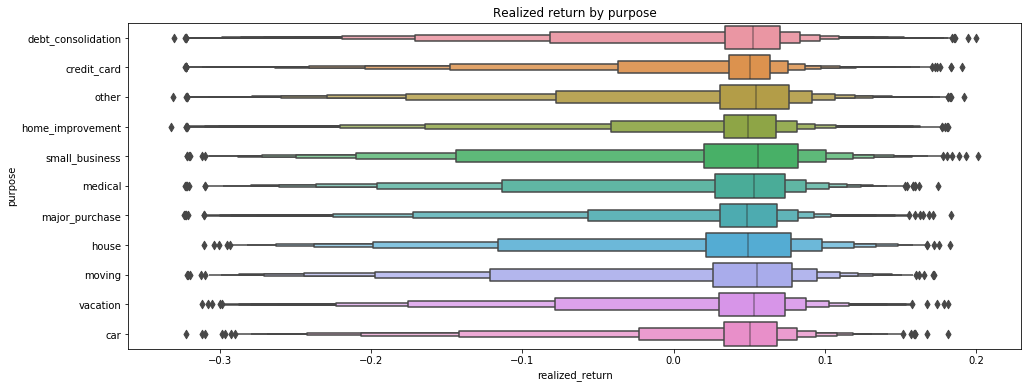

In [28]:
plt.figure(figsize=(16, 6))
sns.boxenplot(x = "realized_return", y = "purpose" , data = df)
plt.title("Realized return by purpose")

We can see the realized return distrbution is more or a less the same for each purpose

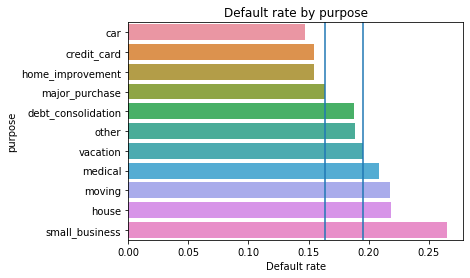

In [29]:
grouped_purpose = df.groupby(["purpose"])['loan_status'].aggregate(np.mean).reset_index().sort_values('loan_status')

s = sns.barplot(x= "loan_status", y ="purpose" , data = grouped_purpose)
plt.axvline(x=0.1636)
plt.axvline(x=0.1952)
plt.title("Default rate by purpose")
plt.xlabel("Default rate")
# s.set_xticklabels(s.get_xticklabels(),rotation=45)
plt.show()

The lines seen on the plot will be our separting cratiria for the "puropse" values, values will be divided to theaese 3 subgroups decided by their deafualt rate, labled 1,2 and 3.

In [30]:
df = df.replace({'purpose': {'car': 1, 'credit_card': 1, 'home_improvement': 1, 'major_purchase': 1, 'debt_consolidation': 2, 'other': 2,
                             'vacation': 2, 'medical': 3, 'moving': 3,
                             'house': 3, 'small_business': 3}})

In [31]:
district_cols = district_cols.drop("purpose")

For 'home_ownership', 'verification_status' and 'addr_state' we will use one hot encoding

In [32]:
for col in district_cols:
    dummies = pd.get_dummies(df[col])
    df = pd.concat([df, dummies], axis=1)
    df.drop(col, axis=1, inplace=True)

# Dealing with outliers

Before detecting outliers we want to recall the distrabution of the realized return between fully paid and defualted loans

In [33]:
df_paid = df[df["loan_status"] == 0]
df_default = df[df["loan_status"] == 1]

In [34]:
print("The precentege of fully paid loans with more then 2 precent realized return is %.3f" % (sum(df_paid["realized_return"] > 0.02)/len(df_paid.index) * 100))

The precentege of fully paid loans with more then 2 precent realized return is 98.996


In [35]:
print("The precentege of defauted loans with more then 2 precent realized return is %.3f" % (sum(df_default["realized_return"] > 0.02)/len(df_default.index) * 100))

The precentege of defauted loans with more then 2 precent realized return is 4.999


From this we understand that the majuraty of loans we want to avoid are deaflted, with only 5% of them with good realized return, meaning thease are the loans we want to detect so we can avoid them. In addition this also mean tht if we do a good job detecting fully paid loans, 99% of them will yield us more then 2%.


We detect ouliers using gauusian (3 SD from the mean) method and IQR

In [36]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df1_outliers_iqr = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
df1_outliers_gauss = pd.DataFrame(np.abs(zscore(df)) > 3)
df1_outliers_gauss.columns = df1_outliers_iqr.columns

In [37]:
columns, iqr_outliers, gauss_outliers = [], [], [] #create lists to store outliers count values

for col in df1_outliers_iqr.columns: #loop on all columns to get outlires counts for both methods
    columns.append(col)
    iqr_outliers.append(df1_outliers_iqr[col].sum())
    gauss_outliers.append(df1_outliers_gauss[col].sum())

prop_outliers_iqr = np.array(iqr_outliers)/len(df1_outliers_iqr.index) #Calculate fractions
prop_outliers_gauss = np.array(gauss_outliers)/len(df1_outliers_gauss.index)
df_outliers = pd.DataFrame({'Columns': columns, 'IQR Outliers': iqr_outliers, 'Prop IQR Outliers': prop_outliers_iqr, #create df
                            'Gaussian Outliers': gauss_outliers, 'Prop Gauss Outliers': prop_outliers_gauss})

df_outliers.sort_values("Gaussian Outliers", ascending = False)

,Columns,IQR Outliers,Prop IQR Outliers,Gaussian Outliers,Prop Gauss Outliers
42,realized_return,44529,0.1683,7546,0.0285
25,bc_open_to_buy,22389,0.0846,5726,0.0216
35,pct_tl_nvr_dlq,15417,0.0583,5161,0.0195
40,total_bc_limit,16660,0.0630,5147,0.0195
19,total_bal_il,16640,0.0629,5042,0.0191
39,total_bal_ex_mort,15864,0.0600,4876,0.0184
29,num_bc_sats,13071,0.0494,4785,0.0181
24,avg_cur_bal,15722,0.0594,4765,0.0180
27,mort_acc,9679,0.0366,4761,0.0180
41,total_il_high_credit_limit,13743,0.0519,4655,0.0176


As seen from the table above, there are many more outliers using the IQR method. removing outlires simply based on the IQR cratiria will leave us with significantly less data to work with, even if we increse the threshold. therefor we will focus on the gaussian method results. out target column - relized_return, has the highest number of outliers using this method. before making any rush decidions we wanted to check the nature of the outliers in each columns - are they fully paid or charged off?

In [38]:
# df1_inliers_gauss = pd.DataFrame(np.abs(zscore(df)) <= 3)
# df1_inliers_gauss.columns = df1_outliers_gauss.columns
# df2 = df.copy()

# for col in df2.columns:
#     if col == 'ann_exp_return':
#         df2 = df2[df1_inliers_gauss[col]]
#     else:
#         pass

# print(df2['loan_status'].value_counts())

In [39]:
#check proportion of fully paid/defult loans in columns outlires

df2 = df.copy()
df2 = df2.reset_index(drop = True)
df1_outliers_gauss = pd.DataFrame(np.abs(zscore(df)) > 3)
df1_outliers_gauss.columns = df1_outliers_iqr.columns

column, fully_paid, default = [], [], []

for col in df2:
    if len(df2[df1_outliers_gauss[col]].loan_status.value_counts()) == 0:
        pass
    else:
        column.append(col)
        if col == "realized_return":
            
            fully_paid.append(0)
            default.append(df2[df1_outliers_gauss[col]].loan_status.value_counts()[1])
        else:
            fully_paid.append(df2[df1_outliers_gauss[col]].loan_status.value_counts()[0])
            default.append(df2[df1_outliers_gauss[col]].loan_status.value_counts()[1])
            
            
df_outliers_loan_status = pd.DataFrame({'Columns': column, 'Fully_paid': fully_paid, 'Default': default})
df_outliers_loan_status["frac"] = df_outliers_loan_status.Default/(df_outliers_loan_status.Default + df_outliers_loan_status.Fully_paid)
df_outliers_loan_status.sort_values("frac")

,Columns,Fully_paid,Default,frac
7,fico_range_low,3887,203,0.0496
8,fico_range_high,3887,203,0.0496
21,bc_open_to_buy,5324,402,0.0702
35,total_bc_limit,4673,474,0.0921
20,avg_cur_bal,4317,448,0.0940
19,total_rev_hi_lim,3798,420,0.0996
33,tot_hi_cred_lim,3339,370,0.0998
14,tot_cur_bal,3648,420,0.1032
23,mort_acc,4228,533,0.1120
11,revol_bal,3238,410,0.1124


Most of the coulmns outliers has more or less the same distribution of fully paid/default loans as our data (13% deafult). However, all of realized_return outliers are defualted loans, thease loans 
are exactly the ones we want our model to identify, whether we predict deafult/non-default or the expected realized return (the defualted loans are usarly the ones with negative return and we want to avoid them), therefore we will not drop thease outliers, they contain relavent information. 

For the rest of the outliers, To tred lightly, for now we will only drop outliers that are more then 6 SD from the mean. When we move forword and try to improve out model we will investagate every attribute outliers separtly, try to understand their nature, and check if removing them impact our model.

# Scaling
For now we will test our models with and with out scaling, at this time we will use standart scaler, when we proceed we will try diffrent scaling methods and see if it improves our model

# Modeling

# Approch A - Reggresion model on realized return

## baseline model - predicting by grade

In [40]:
base_line_grade

,mean,median,std,min,max
grade,,,,,
A,0.0320,0.0410,0.0461,-0.3227,0.1007
B,0.0301,0.0558,0.0714,-0.3303,0.1222
C,0.0248,0.0659,0.0936,-0.3319,0.1301
D,0.0189,0.0683,0.1138,-0.3214,0.1575
E,0.0158,0.0677,0.1306,-0.3215,0.1813
F,0.0081,0.0579,0.1453,-0.3305,0.2010
G,-0.0039,0.0332,0.1541,-0.3197,0.1942


In [41]:
only_grade = df[["grade", "realized_return"]]

In [42]:
X = only_grade.drop(["realized_return"], axis = 1)
y = only_grade["realized_return"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=3)

In [43]:
base_model = LinearRegression()
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)

In [44]:
print(" Baseline model predictting by grade: \n R2 --> %.5f \n RMSE --> %.5f" % (r2_score(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)) ) )

 Baseline model predictting by grade: 
 R2 --> 0.00304 
 RMSE --> 0.08319


In [45]:
name, R2, RMSE = [],[],[]

In [46]:
def Reg_model(Name, model, df, scale = False):
    X = df.drop(["loan_status", "realized_return"], axis = 1)
    y = df["realized_return"]
    
    if scale:
        sc = StandardScaler()
        X = sc.fit_transform(X)
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=3)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    name.append(Name)
    R2.append(round(r2_score(y_test,y_pred),5))
    RMSE.append(np.round(np.sqrt(mean_squared_error(y_test,y_pred)),5))
    
    print(" Model --> %s \n R2 --> %.5f \n RMSE --> %.5f" % (Name, r2_score(y_test,y_pred), np.sqrt(mean_squared_error(y_test,y_pred)) ) )
    

In [47]:
LR = LinearRegression()
KNN = KNeighborsRegressor()
GB = GradientBoostingRegressor()

In [48]:
Reg_model("LR", LR, df)
Reg_model("KNN", KNN, df)
Reg_model("GB", GB, df)

 Model --> LR 
 R2 --> 0.01165 
 RMSE --> 0.08283
 Model --> KNN 
 R2 --> -0.18461 
 RMSE --> 0.09068
 Model --> GB 
 R2 --> 0.02078 
 RMSE --> 0.08244


* With scaling:

In [147]:
Reg_model("LR_scaled", LR, df, scale=True)
Reg_model("KNN_scaled", KNN, df, scale=True)
Reg_model("GB_scaled", GB, df, scale=True)

 Model --> LR_scaled 
 R2 --> 0.01188 
 RMSE --> 0.08282
 Model --> KNN_scaled 
 R2 --> -0.16875 
 RMSE --> 0.09007
 Model --> GB_scaled 
 R2 --> 0.02076 
 RMSE --> 0.08245


# Approch B - Classification model on loan status

In [90]:
#name, accuracy, recall, precision, F1 = [], [], [], [], []

In [94]:
def model_classification_results():
    print('Model recall: %.5f' % recall_score(y_test, y_pred))
    print('Model precision_score: %.5f' % precision_score(y_test, y_pred))
    print('Model roc_auc_score: %.5f' % roc_auc_score(y_test, y_pred))
    print('Model accuracy_score: %.5f' % accuracy_score(y_test,y_pred))

    confusion_matrix_pred = pd.DataFrame(confusion_matrix(y_test, y_pred),
                                            columns=pd.MultiIndex.from_product([['Prediction'], ['Fully Paid', 'Charged Off']]),
                                            index=pd.MultiIndex.from_product([['Actual'], ['Fully Paid', 'Charged Off']]))
    print("Model confusion matrix\n")
    print(confusion_matrix_pred)

    df_paid = train_set_status_return[train_set_status_return["loan_status"] == 0]
    df_default = train_set_status_return[train_set_status_return["loan_status"] == 1]

    mean_return_fullypaid = np.mean(df_paid["realized_return"])
    mean_return_chargedoff = np.mean(df_default["realized_return"])

    inv_actual_0_lg, inv_actual_1_lg = confusion_matrix_pred.iloc[0, 0], confusion_matrix_pred.iloc[1, 0]
    total_inv_lg = inv_actual_0_lg + inv_actual_1_lg

    prob_pred_fullypaid_actual_chargedoff_lg = inv_actual_1_lg/total_inv_lg
    prob_pred_fullypaid_actual_fullypaid_lg = inv_actual_0_lg/total_inv_lg

    exp_return_inv_lg = prob_pred_fullypaid_actual_fullypaid_lg * mean_return_fullypaid + \
                        prob_pred_fullypaid_actual_chargedoff_lg * mean_return_chargedoff
    print("Expected mean return %.4f" % exp_return_inv_lg)
    print("")
    print("Real mean return of loans classified as Fully paid %.4f" % np.mean(y_test_relized_return[y_pred == 0])) #calculate the reale mean realized return of loans classified as Fully paid

# Baseline model - predicting by grade

In [95]:
X = df
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [96]:
y_test_relized_return = X_test["realized_return"] #save the real realized return of the test loans
train_set_status_return = X_train[["loan_status", "realized_return"]] #keep the train set status and realized return

In [97]:
#and now drop them
X_train = X_train.drop(['loan_status', 'realized_return'], axis=1)
X_test = X_test.drop(['loan_status', 'realized_return'], axis=1)

In [98]:
X_train = X_train[["grade"]]
X_test = X_test[["grade"]]

In [99]:
base_model = LogisticRegression()
base_model.fit(X_train, y_train)
y_pred = base_model.predict(X_test)

In [100]:
model_classification_results()

Model recall: 0.02293
Model precision_score: 0.42054
Model roc_auc_score: 0.50803
Model accuracy_score: 0.81963
Model confusion matrix

                   Prediction            
                   Fully Paid Charged Off
Actual Fully Paid       43151         299
       Charged Off       9245         217
Expected mean return 0.0275

Real mean return of loans classified as Fully paid 0.0269


In [101]:
X = df
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [102]:
y_test_relized_return = X_test["realized_return"] #save the real realized return of the test loans
train_set_status_return = X_train[["loan_status", "realized_return"]] #keep the train set status and realized return

In [103]:
#and now drop them
X_train = X_train.drop(['loan_status', 'realized_return'], axis=1)
X_test = X_test.drop(['loan_status', 'realized_return'], axis=1)

# Logistic regression - not scaled 

In [ ]:
# logistic regression
LG = LogisticRegression(max_iter = 400)
LG.fit(X_train, y_train)

In [105]:
threshold = 0.5 #set threshold for classification decidion
y_prob = LG.predict_proba(X_test)[:, 1] # get probability
y_pred = (y_prob >= threshold).astype('int')

In [106]:
model_classification_results()

Model recall: 0.00021
Model precision_score: 0.66667
Model roc_auc_score: 0.50009
Model accuracy_score: 0.82119
Model confusion matrix

                   Prediction            
                   Fully Paid Charged Off
Actual Fully Paid       43449           1
       Charged Off       9460           2
Expected mean return 0.0270

Real mean return of loans classified as Fully paid 0.0270


# Knn - Not scaled

In [107]:
# logistic regression
Knn = KNeighborsClassifier()
Knn.fit(X_train, y_train)

KNeighborsClassifier()

In [108]:
threshold = 0.5 #set threshold for classification decidion
y_prob = Knn.predict_proba(X_test)[:, 1] # get probability
y_pred = (y_prob >= threshold).astype('int')

In [109]:
model_classification_results()

Model recall: 0.06669
Model precision_score: 0.22560
Model roc_auc_score: 0.50842
Model accuracy_score: 0.79216
Model confusion matrix

                   Prediction            
                   Fully Paid Charged Off
Actual Fully Paid       41284        2166
       Charged Off       8831         631
Expected mean return 0.0275

Real mean return of loans classified as Fully paid 0.0272


# Random forest - not scaled

In [110]:
# logistic regression
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

RandomForestClassifier()

In [111]:
threshold = 0.5 #set threshold for classification decidion
y_prob = RF.predict_proba(X_test)[:, 1] # get probability
y_pred = (y_prob >= threshold).astype('int')

In [112]:
model_classification_results()

Model recall: 0.02547
Model precision_score: 0.49084
Model roc_auc_score: 0.50986
Model accuracy_score: 0.82100
Model confusion matrix

                   Prediction            
                   Fully Paid Charged Off
Actual Fully Paid       43200         250
       Charged Off       9221         241
Expected mean return 0.0276

Real mean return of loans classified as Fully paid 0.0273


# Logistic regression - scaled 

In [113]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [117]:
# logistic regression
LG = LogisticRegression(max_iter =  500)
LG.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [118]:
threshold = 0.5 #set threshold for classification decidion
y_prob = LG.predict_proba(X_test)[:, 1] # get probability
y_pred = (y_prob >= threshold).astype('int')

In [119]:
model_classification_results()

Model recall: 0.03657
Model precision_score: 0.49928
Model roc_auc_score: 0.51429
Model accuracy_score: 0.82116
Model confusion matrix

                   Prediction            
                   Fully Paid Charged Off
Actual Fully Paid       43103         347
       Charged Off       9116         346
Expected mean return 0.0279

Real mean return of loans classified as Fully paid 0.0272


# Knn - Scaled

In [113]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [114]:
# logistic regression
Knn = KNeighborsClassifier()
Knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
threshold = 0.5 #set threshold for classification decidion
y_prob = Knn.predict_proba(X_test)[:, 1] # get probability
y_pred = (y_prob >= threshold).astype('int')

In [ ]:
model_classification_results()

# Random forest - scaled

In [ ]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [ ]:
# logistic regression
RF = RandomForestClassifier()
RF.fit(X_train, y_train)

In [ ]:
threshold = 0.5 #set threshold for classification decidion
y_prob = RF.predict_proba(X_test)[:, 1] # get probability
y_pred = (y_prob >= threshold).astype('int')

In [ ]:
model_classification_results()